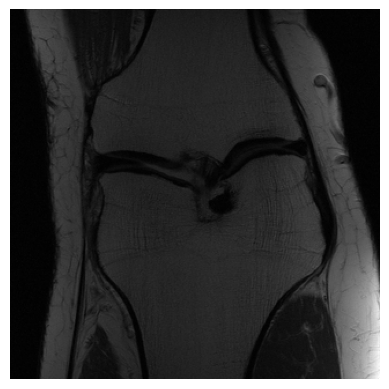

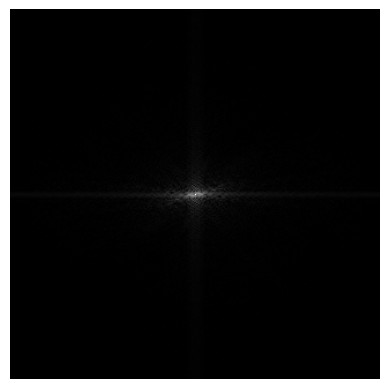

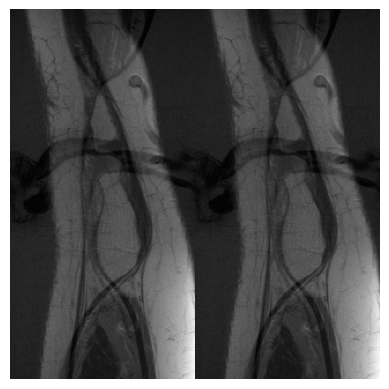

In [43]:
import os
import sys
import fastmri
import fastmri.data
import fastmri.data.transforms
import h5py
import torch

# Set the path to the root of your project
project_root = os.path.abspath(os.path.join(os.getcwd(), r"C:\Users\kostanjsek\bachelor_project"))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

import numpy as np
import matplotlib.pyplot as plt
from MAP.masks import (
    SimpleMask,
    BernoulliMask,
    CenteredBernoulliMask,
    SimpleMask2D,
    VariableDensityMask,
    PseudoRandomColumnMask
)
from fastmri.data import transforms as T
from fastmri.data.subsample import MaskFunc, RandomMaskFunc
from MAP.map_tv_minimize import MAPEstimator
from fastmri.data.mri_data import SliceDataset
from data.load_knee_mri import load_fastmri_data
from MMSE.mmse_ula import MMSEEstimatorULA
import skimage as ski

shepp_logan = ski.data.shepp_logan_phantom()

train_dataset, val_dataset, test_dataset = load_fastmri_data(
    r"C:\Users\kostanjsek\Documents\knee_mri"
)

file_name = r"C:\Users\kostanjsek\Documents\knee_mri\knee_singlecoil_train\singlecoil_train/file1000662.h5"
hf = h5py.File(file_name)

# def load_fastmri_sample(dataset, index):

#     file_path = dataset[index]
#     with h5py.File(file_path, 'r') as f:
#         keys = list(f.keys())
#         kspace = f['kspace'][:]
#         target = f['reconstruction_rss'][:] if 'reconstruction_rss' in f else None

#     return {
#         "keys": keys,
#         "kspace": kspace,
#         "target": target
#     }


volume_kspace = hf['kspace'][()]
target = hf['reconstruction_rss'][()]

slice_kspace = volume_kspace[20]
slice_target = target[20]  # match slice index to kspace slice
tensor_kspace = T.to_tensor(slice_kspace)

#mask = BernoulliMask(0.75, seed=30).generate(slice_target.shape)
#mask = VariableDensityMask('polynomial', 2, seed=30).generate(slice_kspace.shape)
#mask = VariableDensityMask('gaussian', 1.5, seed=30).generate(slice_target.shape)
#mask = PseudoRandomColumnMask(slice_target.shape, acceleration=2, seed=30).get_mask()
#mask = CenteredBernoulliMask(0.75, 0.25, seed=30).generate(slice_target.shape)

#mask = SimpleMask(4).mask_columns(slice_target)
mask = SimpleMask(2).mask_columns(slice_target)
shepp_mask = SimpleMask2D(4,4).get_mask(shepp_logan)

y = mask * np.fft.fft2(slice_target) # mask * slice_kspace
y_norm = y / np.max(np.abs(y))

y_shepp = shepp_mask * np.fft.fft2(shepp_logan)
y_shepp_norm = y_shepp / np.max(np.abs(y_shepp))

# map_estimator = MAPEstimator(mask, 0.95, 0.01, 1e-2, 0.1, 100) # def-> 0.95, 0.01, 1e-2, 0.1, 100)
# mmse_estimator = MMSEEstimatorULA(mask, 0.001, 0.001, 1e-2, 0.1, 150, 50e-2, 50, 2, 100) # stepsize = 1e-2

# map_reconstruct = map_estimator.subgradient_descent(y)

# samples, energies = mmse_estimator.ula_mmse(y_norm)

# mmse_image = np.mean(samples, axis=0)

# target
plt.imshow(slice_target / slice_target.max(), cmap="gray")
plt.axis("off")
plt.show()

# show mask
plt.imshow(np.log(0.1 + np.abs(np.fft.fftshift(np.fft.fft2(slice_target)))), cmap="gray")
plt.axis("off")
plt.show()

np.fft.fftshift
#plt.imshow(slice_kspace, cmap='gray')
#plt.axis("off")
#plt.show()

#ifft of masked kspace
plt.imshow(np.abs(np.fft.ifft2(y)), cmap="gray")
plt.axis("off")
plt.show()